### Emulating a controller with an LSTM Network

The purpose of this exercise is to automate a temperature control process with an LSTM network. The LSTM network is trained from a PID (Proportional Integral Derivative) controller or a Model Predictive Controller (MPC). LSTM (Long Short Term Memory) networks are a special type of RNN (Recurrent Neural Network) that is structured to remember and predict based on long-term dependencies that are trained with time-series data. An LSTM repeating module has four interacting components.

<img align=left width=400px src='https://apmonitor.com/pds/uploads/Main/lstm_automation.png'>

The LSTM is trained (parameters adjusted) with an input window of prior data and minimized difference between the predicted and next measured value. Sequential methods predict just one next value based on the window of prior data. In this case, the error between the set point and measured value is the feature and the heater value is the output label.

See [Automation with LSTM Network](https://apmonitor.com/pds/index.php/Main/LSTMAutomation) for additional details.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from tqdm import tqdm # Progress bar

# For scaling, feature selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split 

# For LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from keras.models import load_model

# For TCLab
import tclab

### Initialize TCLab Emulator with 100x speedup

The [TCLab emulator (digital twin)](https://tclab.readthedocs.io/en/latest/notebooks/04_Emulation_of_TCLab_for_Offline_Use.html) can run faster than real-time. Use 100x speedup with the simulator. Optionally, use the TCLab to generate the training data.

In [2]:
speedup = 100
TCLab = tclab.setup(connected=False, speedup = speedup)

### Program PID controller 

Apply this emulated control on the physical TCLab controller. Use the emulator for training.

In [3]:
# PID Parameters
Kc   = 6.0
tauI = 75.0 # sec
tauD = 0.0  # sec

#-----------------------------------------
# PID Controller
#-----------------------------------------

def pid(sp,pv,pv_last,ierr,dt):
    # PID coefficients in terms of tuning parameters
    KP = Kc
    KI = Kc / tauI
    KD = Kc * tauD
    
    # ubias for controller (initial heater)
    op0 = 0 
    
    # upper and lower bounds on heater level
    ophi = 100
    oplo = 0
    
    # calculate the error
    error = sp - pv
    
    # calculate the integral error
    ierr = ierr + KI * error * dt
    
    # calculate the measurement derivative
    if dt>=1e-8:
        dpv = (pv - pv_last) / dt
    else:
        dpv = 0.0;
    
    # calculate the PID output
    P = KP * error
    I = ierr
    D = -KD * dpv
    op = op0 + P + I + D
    
    # implement anti-reset windup
    if op < oplo or op > ophi:
        I = I - KI * error * dt
        # clip output
        op = max(oplo,min(ophi,op))
        
    # return the controller output and PID terms
    return [op,P,I,D]

### Optional: Use MPC (Model Predictive Control)

See the last example for [MPC with TCLab](https://apmonitor.com/pds/notebooks/12_time_series.html). This is an optional controller that you can implement instead of PID control.

In [4]:
#def mpc(input_parameters):    
#    return Q1

### Generate data for training LSTM

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


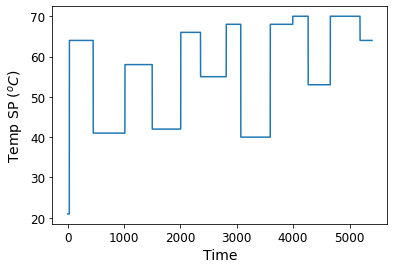

In [5]:
##### Set up run parameters #####

# Run time in minutes
run_time = 90.0

# Number of cycles
loops = int(60.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
Q1 = np.zeros(loops) # Heater values
tm = np.zeros(loops) # Time

# Temperature set point (degC)
with TCLab() as lab:
    Tsp1 = np.ones(loops) * lab.T1

# vary temperature setpoint
end = 30 # leave 1st 30 seconds of temp set point as room temp
while end <= loops:
    start = end
    # keep new temp set point value for anywhere from 4 to 10 min
    end += random.randint(240,600) 
    Tsp1[start:end] = random.randint(30,70)

# Plot
plt.plot(Tsp1)
plt.xlabel('Time',size=14)
plt.ylabel(r'Temp SP ($^oC$)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.savefig('SP_profile.png');

### Data Collection

In [6]:
# Data collection

with TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0
    
    prev_time = 0
    for i,t in enumerate(tclab.clock(loops-1)):
        tm[i] = t
        dt = t - prev_time
        
        # Read temperatures in Kelvin 
        T1[i] = lab.T1

        # Integral absolute error
        iae += np.abs(Tsp1[i]-T1[i])

        # Calculate PID output
        [Q1[i],P,ierr,D] = pid(Tsp1[i],T1[i],T1[i-1],ierr,dt)
        
        # Calculate MPC output

        # Write heater output (0-100)
        lab.Q1(Q1[i])

        # Print line of data
        if i%100==0:
            print(('{:6.1f} {:6.2f} {:6.2f} ' + \
                  '{:6.2f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}').format( \
                      tm[i],Tsp1[i],T1[i], \
                      Q1[i],P,ierr,D,iae))
        
        prev_time = t
        


TCLab version 0.4.9
Simulated TCLab
Temperature 1: 20.95 °C
Temperature 2: 20.63 °C
   0.0  20.95  20.63   1.93   1.93   0.00  -0.00   0.32
 157.9  64.00  49.63  97.83  86.19  11.63  -0.00 2070.67
 312.8  64.00  63.49  72.24   3.04  69.20  -0.00 2533.58
 468.1  64.00  64.14  71.07  -0.83  71.89  -0.00 2558.02
 625.0  64.00  64.14  71.08  -0.83  71.90  -0.00 2573.81
 780.9  41.00  49.96   8.11 -53.74  61.85   0.00 3387.58
 938.0  41.00  41.25  33.38  -1.53  34.91  -0.00 3601.88
1092.8  41.00  40.93  34.20   0.41  33.79  -0.00 3617.81
1247.8  41.00  40.93  34.25   0.41  33.84  -0.00 3628.33
1402.6  41.00  41.25  32.20  -1.53  33.72  -0.00 3639.60
1557.6  41.00  40.93  34.18   0.41  33.77  -0.00 3650.12
1713.4  58.00  57.69  63.60   1.85  61.75  -0.00 4252.24
1867.9  58.00  57.69  63.47   1.85  61.62   0.00 4255.79
2022.0  58.00  58.01  61.72  -0.08  61.80  -0.00 4259.83
2176.2  58.00  57.69  63.76   1.85  61.91   0.00 4263.29
2329.9  42.00  58.01   0.00 -96.08  61.89  -0.00 4281.87
2484.

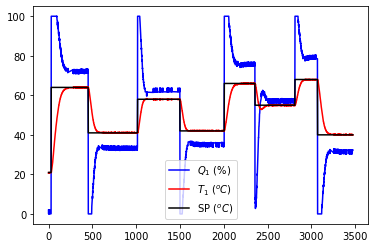

In [7]:
# Save csv file
df = pd.DataFrame()
df['Q1'] = Q1[:i]
df['Q1'].fillna(0,inplace=True)
df['T1'] = T1[:i]
df['Tsp'] = Tsp1[:i]
df.to_csv('PID_train_data.csv',index=False)

# Plot
plt.plot(df['Q1'],'b-',label='$Q_1$ (%)')
plt.plot(df['T1'],'r-',label='$T_1$ $(^oC)$')
plt.plot(df['Tsp'],'k-',label='SP $(^oC)$')
plt.legend()
plt.savefig('PID_train.png');

### Feature engineering: create SP error feature and analyze feature importance

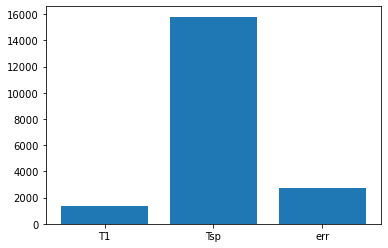

In [8]:
# Create new feature: setpoint error
df['err'] = df['Tsp'] - df['T1']

# Load possible features
X = df[['T1','Tsp','err']]
y = np.ravel(df[['Q1']])

# SelectKBest feature selection
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(X,y)
plt.bar(x=X.columns,height=fit.scores_);

### Feature selection, scaling, and formatting data to LSTM input format

In [9]:
X = df[['Tsp','err']].values
y = df[['Q1']].values

# Scale data
s_x = MinMaxScaler()
Xs = s_x.fit_transform(X)

s_y = MinMaxScaler()
ys = s_y.fit_transform(y)

# Each input uses last 'window' number of Tsp and err to predict the next Q1
window = 15
X_lstm = []
y_lstm = []
for i in range(window,len(df)):
    X_lstm.append(Xs[i-window:i])
    y_lstm.append(ys[i])

# Reshape data to format accepted by LSTM
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

# Split into train and test 
Xtrain, Xtest, ytrain, ytest = train_test_split(X_lstm,y_lstm,test_size=0.2,shuffle=False)

### Keras LSTM 

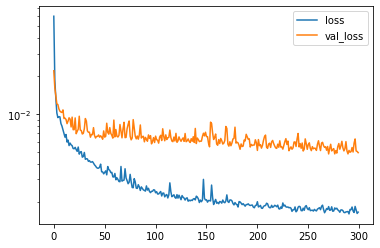

In [10]:
# Keras LSTM model
model = Sequential()

# First layer specifies input_shape and returns sequences
model.add(LSTM(units=100, return_sequences=True, 
               input_shape=(Xtrain.shape[1],Xtrain.shape[2])))
# Dropout layer to prevent overfitting
model.add(Dropout(rate=0.1))

# Last layer doesn't return sequences (middle layers should return sequences)
model.add(LSTM(units=100))
model.add(Dropout(rate=0.1))

# Dense layer to return prediction
model.add(Dense(1))

# Compile model; adam optimizer, mse loss
model.compile(optimizer='adam', loss='mean_squared_error')

es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)

result = model.fit(Xtrain, ytrain, verbose=0, validation_split=0.2,
                   callbacks = [TqdmCallback(verbose=1)],#es
                   batch_size=100,
                   epochs=300)

# Plot loss and save model
epochs = es.stopped_epoch
plt.semilogy(result.history['loss'],label='loss')
plt.semilogy(result.history['val_loss'],label='val_loss')
plt.legend()

model.save('lstm_control.h5')

### Preliminary model performance assessment

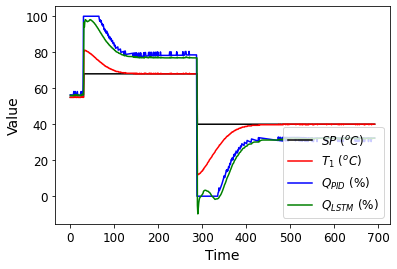

In [11]:
# Predict using LSTM
yp_s = model.predict(Xtest)

# Unscale data
Xtest_us = s_x.inverse_transform(Xtest[:,-1,:])
ytest_us = s_y.inverse_transform(ytest)
yp = s_y.inverse_transform(yp_s)

# Derive Tsp (sp) and T1 (pv) from X data
sp = Xtest_us[:,0]
pv = Xtest_us[:,0] + Xtest_us[:,1]

# Plot SP, PID response, and LSTM response
plt.plot(sp,'k-',label='$SP$ $(^oC)$')
plt.plot(pv,'r-',label='$T_1$ $(^oC)$')
plt.plot(ytest_us,'b-',label='$Q_{PID}$ (%)')
plt.plot(yp,'g-',label='$Q_{LSTM}$ (%)')
plt.legend(fontsize=12,loc='lower right')
plt.xlabel('Time',size=14)
plt.ylabel('Value',size=14)
plt.xticks(size=12)
plt.yticks(size=12);

### Generate SP data for test

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


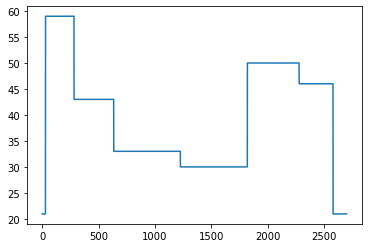

In [12]:
# Run time in minutes
run_time = 45.0

# Number of cycles
loops = int(60.0*run_time)

# arrays for storing data
T1 = np.zeros(loops) # measured T (degC)
Qpid = np.zeros(loops) # Heater values for PID controller
Qlstm = np.zeros(loops) # Heater values for LSTM controller
tm = np.zeros(loops) # Time

# Temperature set point (degC)
with TCLab() as lab:
    Tsp = np.ones(loops) * lab.T1

# vary temperature setpoint
end = window + 15 # leave 1st window + 15 seconds of temp set point as room temp
while end <= loops: 
    start = end
    # keep new temp set point value for anywhere from 4 to 10 min
    end += random.randint(240,600) 
    Tsp[start:end] = random.randint(30,70)
    
# leave last 120 seconds as room temp
Tsp[-120:] = Tsp[0]

plt.plot(Tsp);

### Part A: Run the controller with the PID, but also output the LSTM for comparison

In [13]:
#-----------------------------------------
# LSTM Controller
#-----------------------------------------

def lstm(T1_m, Tsp_m):
    # Calculate error (necessary feature for LSTM input)
    err = Tsp_m - T1_m
    
    # Format data for LSTM input
    X = np.vstack((Tsp_m,err)).T
    Xs = s_x.transform(X)
    Xs = np.reshape(Xs, (1, Xs.shape[0], Xs.shape[1]))
    
    # Predict Q for controller and unscale
    Q1c_s = model.predict(Xs)
    Q1c = s_y.inverse_transform(Q1c_s)[0][0]
    
    # Ensure Q1c is between 0 and 100
    Q1c = np.clip(Q1c,0.0,100.0)
    
    return Q1c

In [14]:
# Run test
with TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Integral error
    ierr = 0.0
    # Integral absolute error
    iae = 0.0
    
    start_time = 0
    prev_time = 0
    for i,t in enumerate(tclab.clock(loops)):
        tm[i] = t
        dt = t - prev_time

        # Read temperature (C)
        T1[i] = lab.T1

        # Integral absolute error
        iae += np.abs(Tsp[i]-T1[i])

        # Calculate PID output
        [Qpid[i],P,ierr,D] = pid(Tsp[i],T1[i],T1[i-1],ierr,dt)

        # Write heater output (0-100)
        lab.Q1(Qpid[i])
        
        # Run LSTM model to get Q1 value for control
        if i >= window:
            # Load data for model
            T1_m = T1[i-window:i]
            Tsp_m = Tsp[i-window:i]
            # Predict and store LSTM value for comparison
            Qlstm[i] = lstm(T1_m,Tsp_m)
            
        prev_time = t

TCLab version 0.4.9
Simulated TCLab
Temperature 1: 20.95 °C
Temperature 2: 20.95 °C
TCLab Model disconnected successfully.


(array([  0.,  20.,  40.,  60.,  80., 100.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

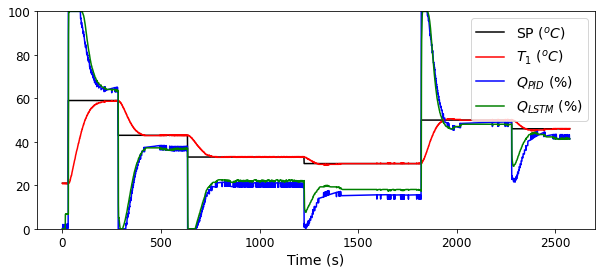

In [15]:
plt.figure(figsize=(10,4))
plt.plot(Tsp[:i],'k-',label='SP $(^oC)$')
plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
plt.plot(Qpid[:i],'b-',label='$Q_{PID}$ (%)')
plt.plot(Qlstm[:i],'g-',label='$Q_{LSTM}$ (%)')
plt.legend(loc='upper right',fontsize=14)
plt.ylim((0,100))
plt.xlabel('Time (s)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)

### Part B: Run the controller with just the LSTM

In [19]:
# Run test
loops = 300
with TCLab() as lab:
    # Find current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))
    
    start_time = 0
    prev_time = 0
    for i,t in enumerate(tclab.clock(loops)):
        tm[i] = t
        dt = t - prev_time

        # Read temperature (C)
        T1[i] = lab.T1

        # Run LSTM model to get Q1 value for control
        if i >= window:
            # Load data for model
            T1_m = T1[i-window:i]
            Tsp_m = Tsp[i-window:i]
            # Predict and store LSTM value for comparison
            Qlstm[i] = lstm(T1_m,Tsp_m)

        # Write heater output (0-100)
        lab.Q1(Qlstm[i])
        
        prev_time = t

TCLab version 0.4.9
Simulated TCLab
Temperature 1: 20.95 °C
Temperature 2: 20.95 °C
0 300
1 300
2 300
3 300
4 300
5 300
6 300
7 300
8 300
9 300
10 300
11 300
12 300
13 300
14 300
15 300
16 300
17 300
18 300
19 300
20 300
21 300
22 300
23 300
24 300
25 300
26 300
27 300
28 300
29 300
30 300
31 300
32 300
33 300
34 300
35 300
36 300
37 300
38 300
39 300
40 300
41 300
42 300
43 300
44 300
45 300
46 300
47 300
48 300
49 300
50 300
51 300
52 300
53 300
54 300
55 300
56 300
57 300
58 300
59 300
60 300
61 300
62 300
63 300
64 300
65 300
66 300
67 300
68 300
69 300
70 300
71 300
72 300
73 300
74 300
75 300
76 300
77 300
78 300
79 300
80 300
81 300
82 300
83 300
84 300
85 300
86 300
87 300
88 300
89 300
90 300
91 300
92 300
93 300
94 300
95 300
96 300
97 300
98 300
99 300
100 300
101 300
102 300
103 300
104 300
105 300
106 300
107 300
108 300
109 300
110 300
111 300
112 300
113 300
114 300
115 300
116 300
117 300
118 300
119 300
120 300
121 300
122 300
123 300
124 300
125 300
126 300
127 300
12

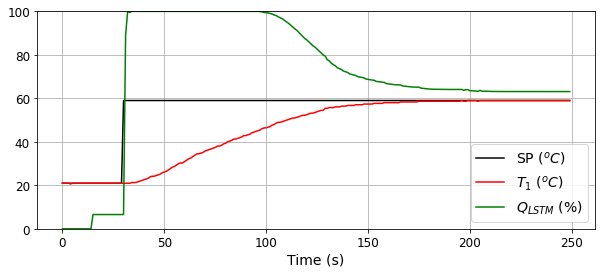

In [23]:
plt.figure(figsize=(10,4))
plt.plot(Tsp[:i],'k-',label='SP $(^oC)$')
plt.plot(T1[:i],'r-',label='$T_1$ $(^oC)$')
plt.plot(Qlstm[:i],'g-',label='$Q_{LSTM}$ (%)')
plt.legend(fontsize=14)
plt.ylim((0,100))
plt.xlabel('Time (s)',size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.grid()
plt.show()

### Part C

Use the LSTM controller to control the [TCLab microcontroller](https://apmonitor.com/heat.htm) or [Emulated TCLab](https://tclab.readthedocs.io/en/latest/notebooks/04_Emulation_of_TCLab_for_Offline_Use.html) from a separate program. Demonstrate that you can [package and deploy the LSTM model](https://apmonitor.com/pds/index.php/Main/DeployMachineLearning) so that it could be used on a different computer than the training computer. The application does not necessarily need to run on a separate computer, but show that it is a separate program and independent of this training notebook.

<img align=left width=150px src='https://apmonitor.com/pds/uploads/Main/deploy_machine_learning.png'>

<img align=left width=400px src='https://apmonitor.com/pdc/uploads/Main/tclab_connect.png'>

In [24]:
import pickle
# export model name and scaling
z = ['lstm_control.h5',s_x,s_y]
pickle.dump(z,open('lstm_control.pkl','wb'))